In [1]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe'
from matplotlib import pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete

In [2]:
class WebGame(Env):
    def __init__ (self):
        #Subclass model
        super().__init__()
        self.observation_space = Box(low = 0, high = 255, shape = (1,83,100), dtype = np.uint8) 
        self.action_space = Discrete(3)
        #Define extraction  parametres for the game
        self.cap = mss()
        self.game_location = {'top':300, 'left':0, 'width':600, 'height':500} 
        self.done_location = {'top':405, 'left':630, 'width':660, 'height':70} 


    def step(self, action):
        # Action Key - 0 space, 1 - down, 2 - no action 
        action_map = {
            0:'space',
            1:'down',
            2:'no_op',

        }
        if action != 2:
            pydirectinput.press(action_map[action])

        # Checking whether the game is done
        done, done_cap = self.get_done()
        # Get the next observation
        new_observation = self.get_observation()
        # Reward - we get a point for every frame we are alive
        reward = 1 
        # info directory
        info = {}
       
        return new_observation, reward, done, info
        
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
        
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=250, y=250)
        pydirectinput.press('space')
        return self.get_observation()
        
    def close(self):
        cv2.destroyAllWindows()
        
    def get_observation(self):
        #Get screen capture
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

In [3]:
env = WebGame()

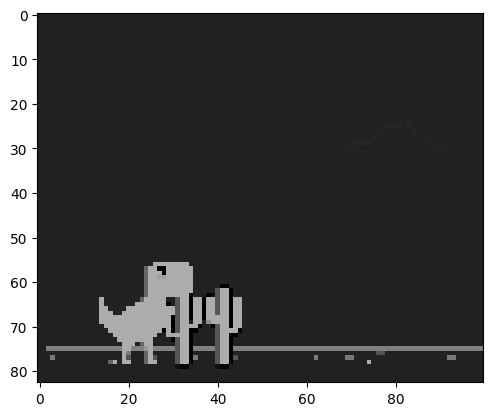

In [56]:
obs=env.get_observation()
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

'q 1 '

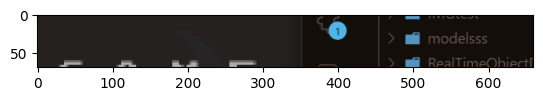

In [57]:
done, done_cap = env.get_done()
plt.imshow(done_cap)
pytesseract.image_to_string(done_cap)[:4]

In [58]:
done

False

In [61]:

for episode in range(15): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward)) 

Total Reward for episode 0 is 9
Total Reward for episode 1 is 8
Total Reward for episode 2 is 10
Total Reward for episode 3 is 8
Total Reward for episode 4 is 8
Total Reward for episode 5 is 8
Total Reward for episode 6 is 8
Total Reward for episode 7 is 8
Total Reward for episode 8 is 19
Total Reward for episode 9 is 9
Total Reward for episode 10 is 9
Total Reward for episode 11 is 8
Total Reward for episode 12 is 8
Total Reward for episode 13 is 8
Total Reward for episode 14 is 8


In [4]:
import os 

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [30]:
env_checker.check_env(env)

In [5]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [6]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [7]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [8]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack


In [9]:
env = WebGame()

In [10]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=12000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [11]:
import tensorboard
model.learn(total_timesteps=150000, callback=callback)

Logging to ./logs/DQN_9
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12       |
|    ep_rew_mean      | 12       |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 35       |
|    total_timesteps  | 48       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.6     |
|    ep_rew_mean      | 10.6     |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 62       |
|    total_timesteps  | 85       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.2     |
|    ep_rew_mean      | 10.2     |
|    exploration_rate | 0.992    |
| time/               |        

KeyboardInterrupt: 

In [23]:
model.load('train/best_model_80000') 

In [24]:
for episode in range(15): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)

Total Reward for episode 0 is 20
Total Reward for episode 1 is 19
Total Reward for episode 2 is 8
Total Reward for episode 3 is 9
Total Reward for episode 4 is 13
Total Reward for episode 5 is 10
Total Reward for episode 6 is 8
Total Reward for episode 7 is 8
Total Reward for episode 8 is 8
Total Reward for episode 9 is 8
Total Reward for episode 10 is 8
Total Reward for episode 11 is 8
Total Reward for episode 12 is 11
Total Reward for episode 13 is 9
Total Reward for episode 14 is 9
